<a href="https://colab.research.google.com/github/iveiras/webis_clickbait_17_challenge/blob/main/webis-17_clickbait_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Webis-17 Clickbait Detection Challenge

## 0. Install needed libraries and load them

In [1]:
!pip install scikit-plot
!pip install transformers
!pip install plotly

     |████████████████████████████████| 4.0 MB 7.8 MB/s 
     |████████████████████████████████| 596 kB 11.6 MB/s 
     |████████████████████████████████| 895 kB 62.9 MB/s 
     |████████████████████████████████| 6.5 MB 40.1 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install plotly

In [3]:
# General libraries
import re
import pandas as pd
import numpy as np

# EDA libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.offline import iplot
import seaborn as sns

# TF-Training libraries
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dropout, Dense, Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Transformers
from transformers import DistilBertTokenizerFast, BertTokenizerFast
from transformers import TFBertModel, BertConfig
from transformers import TFDistilBertModel, DistilBertConfig

# NLTK libraries
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Metrics libraries
import scikitplot as skplt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


## 1. Load and preprocess data

In [4]:
# Load csv datasets
webis_train = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv"
webis_test = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv"
df_train = pd.read_csv(webis_train)
df_test = pd.read_csv(webis_test)

In [5]:
# Print head of dataframe
df_train.head()

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333
3,3,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000
4,4,[],Tokyo's subway is shut down amid fears over an...,858283602626347008,"[""All nine lines of Tokyo's subway system were...","[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000


In [6]:
# Filter only importante variables
df_train = df_train[['postText', 'truthClass']]
df_test = df_test[['postText', 'truthClass']]

# Remove empty rows
df_train['postText'].replace('', np.nan, inplace=True)
df_train.dropna(subset=['postText'], inplace=True)

df_test['postText'].replace('', np.nan, inplace=True)
df_test.dropna(subset=['postText'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2. EDA & Data engineering

In this EDA we will check three important aspects from the dataset (inspired by [Parul Pandey's work](https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert/notebook)):
* Length of the tweets (should be $\leq$ 140)
* Worcount
* Wordcloud

The wordcount is a key factor into correctly defining the padding needed in the BERT models that we will use in the next section to classify the tweets.

We will also see if there is a relation between those three factors and the clickbait condition of the tweets.

In [7]:
# Examples of clickbait and no-clickbait tweets
print('Clickbait examples: \n', df_train[df_train['truthClass'] == 'clickbait']['postText'].values[:5])
print('No-clickbait examples: \n', df_train[df_train['truthClass'] == 'no-clickbait']['postText'].values[:5])

Clickbait examples: 
 ['this is good' 'Meet the happiest #dog in the world!'
 'The top 10 best selling comic books of all time'
 'Players to know, QBs to watch and more 👀\n\nGuide to Round 2 of the #NFLDraft'
 'White House reporter @alivitali on her first 100 days covering President Trump #trump100days']
No-clickbait examples: 
 ['UK’s response to modern slavery leaving victims destitute while abusers go free'
 'The "forgotten" Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club'
 "Tokyo's subway is shut down amid fears over an imminent North Korean missile attack on Japan"
 'Ban lifted on Madrid doping laboratory'
 'Despite the ‘Yuck Factor,’ Leeches Are Big in Russian Medicine']


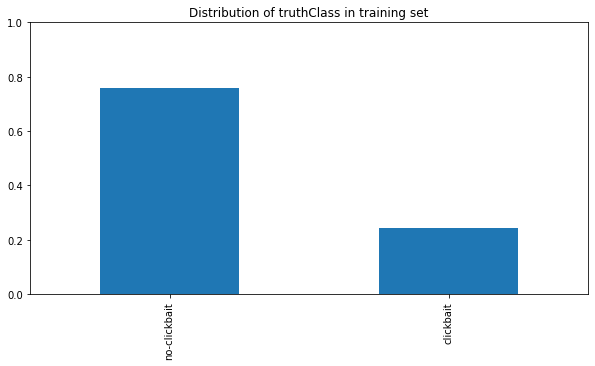

In [8]:
# df_train truthClass distribution
df_train['truthClass'].value_counts(normalize = True).plot(kind='bar', figsize = (10,5), ylim = (0,1),
                                                         title='Distribution of truthClass in training set')

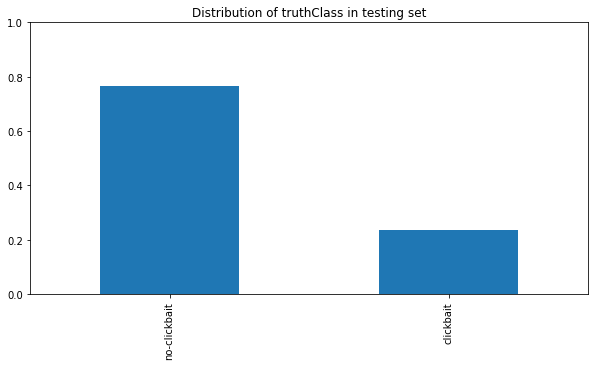

In [9]:
# df_test truthClass distribution
df_test['truthClass'].value_counts(normalize=True).plot(kind = 'bar', figsize = (10,5), ylim = (0,1),
                                                        title = 'Distribution of truthClass in testing set')

In [10]:
# Calculate length of text and wordcount
df_train['length'] = df_train['postText'].apply(len)
df_train['wordcount'] = df_train['postText'].apply(lambda x: len(x.split(' ')))
df_test['length'] = df_test['postText'].apply(len)
df_test['wordcount'] = df_test['postText'].apply(lambda x: len(x.split(' ')))

In [11]:
# Split datasets by labels
clickbait = df_train[df_train['truthClass'] == 'clickbait']
no_clickbait = df_train[df_train['truthClass'] == 'no-clickbait']

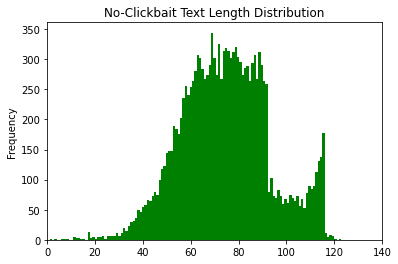

In [12]:
# Plot no-clickbait length distribution
no_clickbait['length'].plot(
    kind = 'hist',
    bins = max(no_clickbait['length']),
    color = 'green',
    xlim = (0, 140),
    title = 'No-Clickbait Text Length Distribution')

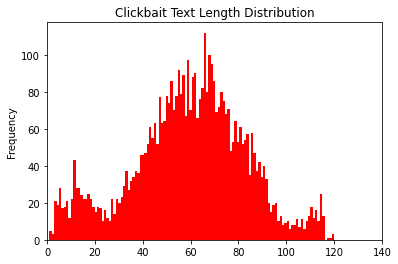

In [13]:
# Plot clickbait length distribution
clickbait['length'].plot(
    kind = 'hist',
    bins = max(clickbait['length']),
    color = 'red',
    xlim = (0, 140),
    title = 'Clickbait Text Length Distribution')

In [14]:
# Plot box-plot lenght distribution by truthClass
trace0 = go.Box(
    y = clickbait['length'],
    name = 'Clickbait Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y = no_clickbait['length'],
    name = 'Non-Clickbait Text',
    marker = dict(
        color = 'green',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "Length of the tweets", yaxis_range = (0, 140)
)

fig = go.Figure(data = data,layout = layout)
iplot(fig, filename = "Length of the tweets of clickbait and non-clickbait")

Max no-clickbait wordcount:  25


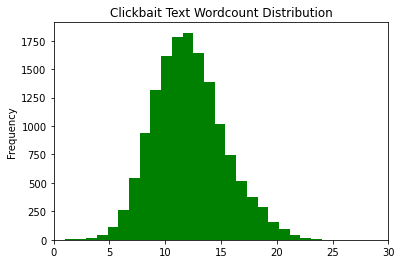

In [15]:
# Plot no-clickbait wordcount distribution
print('Max no-clickbait wordcount: ', max(no_clickbait['wordcount']))
no_clickbait['wordcount'].plot(
    kind = 'hist',
    bins = max(no_clickbait['wordcount']),
    color = 'green',
    xlim = (0, 30),
    title = 'Clickbait Text Wordcount Distribution')

Max clickbait wordcount:  25


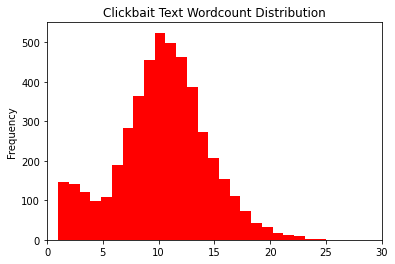

In [16]:
# Plot clickbait wordcount distribution
print('Max clickbait wordcount: ', max(clickbait['wordcount']))
clickbait['wordcount'].plot(
    kind = 'hist',
    bins = max(clickbait['wordcount']),
    color = 'red',
    xlim = (0,30),
    title = 'Clickbait Text Wordcount Distribution')

In [17]:
# Plot box-plot wordcount distribution by truthClass
trace0 = go.Box(
    y = clickbait['wordcount'],
    name = 'Clickbait Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y = no_clickbait['wordcount'],
    name = 'Non-Clickbait Text',
    marker = dict(
        color = 'green',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "wordcount of the tweets", yaxis_range=(0,20)
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = "Wordcount of the tweets of clickbait and non-clickbait")

Text(0.5, 1.0, 'Non-Clickbait tweets')

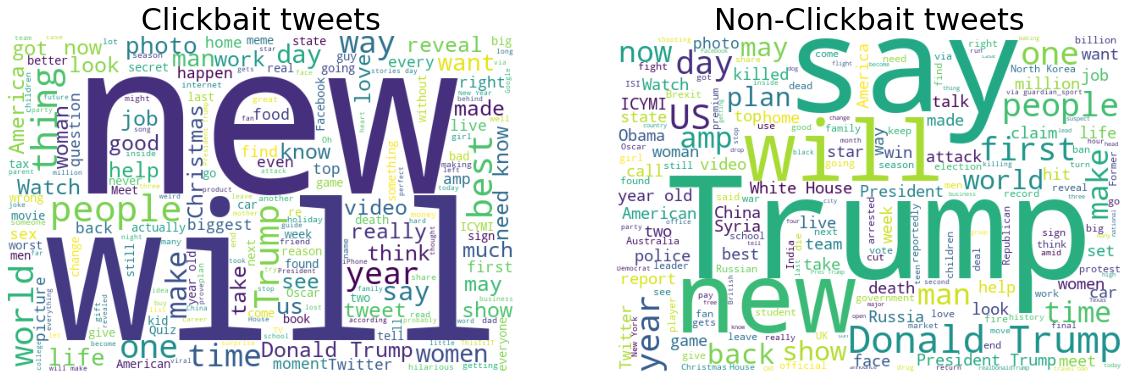

In [18]:
# Plot wordcloud of clickbait and no-clickbait
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 15])
wordcloud1 = WordCloud( background_color = 'white',
                        width = 600,
                        height = 400).generate(' '.join(clickbait['postText']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Clickbait tweets',fontsize = 30)

wordcloud2 = WordCloud( background_color = 'white',
                        width = 600,
                        height = 400).generate(' '.join(no_clickbait['postText']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non-Clickbait tweets', fontsize = 30)

In [19]:
# Factorize labels
df_train['truthClass'] = pd.factorize(df_train['truthClass'])[0]
df_test['truthClass'] = pd.factorize(df_test['truthClass'])[0]

In [20]:
# Split train and validation datasets
df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 42, 
                                      stratify = df_train['truthClass'])

## 3. Main functions and variables

In order to ease the tests that we will perform in the next section, we will previously define some variables and functions that will be helpful for defining, training and evaluating the tests.

In [21]:
# Define model training parameters
MAX_LENGTH = max(max(clickbait['wordcount']), max(no_clickbait['wordcount']))
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
LEARNING_RATE_LSTM = 1e-5
RANDOM_STATE = 42
THRESHOLD = 0.5
EPOCHS = 6
BATCH_SIZE = 64
NUM_STEPS = len(df_train.index) // BATCH_SIZE

In [22]:
# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length = MAX_LENGTH):
  """""""""
  A function that encodes a batch of texts and returns the texts'
  corresponding encodings and attention masks that are ready to be fed 
  into a pre-trained transformer model.

  Input:
      - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
      - texts:       List of strings where each string represents a text
      - batch_size:  Integer controlling number of texts in a batch
      - max_length:  Integer controlling max number of words to tokenize in a given text
  Output:
      - input_ids:       sequence of texts encoded as a tf.Tensor object
      - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
  """""""""
  # Initialize lists to hold the encoded texts and attention masks
  input_ids = []
  attention_mask = []

  # Loop over the texts
  for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    # Create the token_ids for the current batch
    inputs = tokenizer.batch_encode_plus(batch,
                                          max_length = max_length,
                                          padding = 'longest',
                                          truncation = True,
                                          return_attention_mask = True,
                                          return_token_type_ids = False
                                          )
    input_ids.extend(inputs['input_ids'])
    attention_mask.extend(inputs['attention_mask'])

  return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [23]:
def build_model(transformer, max_length=MAX_LENGTH):
  """""""""
  Template for building a model off of the BERT or DistilBERT architecture
  for a binary classification task.
  
  Input:
    - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                    with no added classification head attached.
    - max_length:   integer controlling the maximum number of encoded tokens 
                    in a given sequence.
  
  Output:
    - model:        a compiled tf.keras.Model with added classification layers 
                    on top of the base pre-trained model architecture.
  """""""""
  
  # Define weight initializer with a random seed to ensure reproducibility
  weight_initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_STATE) 
  
  # Define input layers
  input_ids_layer = Input(shape = (max_length,), name = 'input_ids', 
                          dtype = 'int32')
  input_attention_layer = Input(shape = (max_length,), name = 'input_attention',
                                dtype = 'int32')
  
  # BERT models outputs a tuple where the first element at index 0
  # represents the hidden-state at the output of the model's last layer.
  # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
  last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
  
  # Define classification layers 
  cls_token = last_hidden_state[:, 0, :]
  
  D1 = Dropout(LAYER_DROPOUT, seed = RANDOM_STATE)(cls_token)
  
  X = Dense(256, activation = 'relu', kernel_initializer = weight_initializer,
            bias_initializer = 'zeros')(D1)
  
  D2 = Dropout(LAYER_DROPOUT, seed = RANDOM_STATE)(X)
  
  X = Dense(32, activation = 'relu', kernel_initializer = weight_initializer,
            bias_initializer = 'zeros')(D2)
  
  D3 = Dropout(LAYER_DROPOUT, seed = RANDOM_STATE)(X)
  
  # Define a single node that makes up the output layer (for binary classification)
  output = Dense(1, activation = 'sigmoid', kernel_initializer = weight_initializer,
                 kernel_constraint = None, bias_initializer = 'zeros' )(D3)
  
  # Define the model
  model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
  
  # Compile the model
  model.compile(Adam(learning_rate = LEARNING_RATE), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [24]:
def plot_loss_accuracy(train_history):
  """""""""
  A function that plots the training and validation loss and accuracy
  """""""""
  history_dict = train_history.history

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize = (10, 10))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

In [25]:
def accuracy_roc_auc(y_true, y_pred, y_pred_thresh):
  """""""""
  A function that calculates the accuracy and ROC AUC score and plot the results
  """""""""
  # Get evaluation results
  accuracy = accuracy_score(y_true, y_pred_thresh)
  auc_roc = roc_auc_score(y_true, y_pred)

  # Log the ROC curve
  fpr, tpr, thresholds = roc_curve(y_true.to_numpy(), y_pred)

  print('Accuracy:  ', accuracy)
  print('ROC-AUC:   ', auc_roc)

  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 6))
  ax1.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc_roc)
  ax1.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  ax1.axis(xmin = 0.0, xmax = 1.0, ymin = 0.0, ymax = 1.0)
  ax1.set_xlabel('False Positive Rate or (1 - Specifity)')
  ax1.set_ylabel('True Positive Rate or (Sensitivity)')
  ax1.set_title('Receiver Operating Characteristic')
  ax1.legend(loc="lower right")

  precision, recall, _ = precision_recall_curve(y_true, y_pred_thresh)
  ax2.plot(precision, recall, label = 'Test baseline', linewidth = 2)
  ax2.plot([1, 0], [0, 1], label = 'Random limit', linewidth = 1, 
           linestyle = '--', color = 'black')
  ax2.axis(xmin = 0.0, xmax = 1.0, ymin = 0.0, ymax = 1.0)
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Area under the ROC Curve')
  ax2.legend(loc = 'lower left')

  plt.show()

In [26]:
def plot_confusion_matrix(y_true, y_pred_thresh):
  """""""""
  A function that plots the confusion matrix
  """""""""
  # Plot confusion matrix
  skplt.metrics.plot_confusion_matrix(y_true = y_true.to_list(),
                                      y_pred = y_pred_thresh.tolist(),
                                      figsize = (6, 6),
                                      text_fontsize = 14)
  plt.title(label = 'Test Confusion Matrix', fontsize = 20, pad = 17)
  plt.xlabel('Predicted Label', labelpad = 14)
  plt.ylabel('True Label', labelpad = 14)

In [27]:
def plot_density_chart(y_true, y_pred_thresh, threshold = THRESHOLD):
  """""""""
  A function that plots the density chart
  """""""""
  f, ax = plt.subplots(figsize = (10, 8))
  ax = sns.kdeplot(y_pred_thresh[y_true == 0], color = 'green', 
                   label = 'No-clickbait', fill = True, ax = ax)
  ax = sns.kdeplot(y_pred_thresh[y_true == 1], color = 'red', 
                   label = 'Clickbait', fill = True, ax = ax)
  ax.set_title('Density chart')
  plt.axvline(threshold, 0, color = 'blue')
  plt.xlim(-0.1, 1.1)
  plt.legend()
  plt.show(block = False)

## 4. Tests

We will perform three different tests in order to compare the performance and their main characteristics in the next section:
* BERT fine-tuned model - This will be the baseline model
* [DistilBERT fine-tuned model](https://github.com/RayWilliam46/FineTune-DistilBERT/blob/main/notebooks/train_unbalanced.ipynb) - A smaller BERT model
* [RNN (LSTM) model](https://www.analyticsvidhya.com/blog/2021/12/sentiment-analysis-on-tweets-with-lstm-for-beginners/) - A classical DL approach (avoiding transformers)

### 4.1 BERT test

In [28]:
# Configure DistilBERT's initialization
config = BertConfig(dropout = 0.2, attention_dropout = 0.2, 
                    output_hidden_states = True)

# Instantiate fast BERT tokenizer and model with untrainable layers
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
BERT = TFBertModel.from_pretrained('bert-base-uncased')

for layer in BERT.layers:
    layer.trainable = False

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
# Encode the training, validation and test text
X_train_ids_bert, X_train_attention_bert =  \
  batch_encode(bert_tokenizer, df_train['postText'].tolist())

X_valid_ids_bert, X_valid_attention_bert = \
  batch_encode(bert_tokenizer, df_valid['postText'].tolist())

X_test_ids_bert, X_test_attention_bert = \
  batch_encode(bert_tokenizer, df_test['postText'].tolist())

In [30]:
# Instantiate the model and plot the model structure and summary
model_bert = build_model(BERT)
plot_model(model_bert)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 25)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 25)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_attention[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 25,                                            

In [31]:
# Train BERT model
bert_history = model_bert.fit(x = [X_train_ids_bert, X_train_attention_bert],
                              y = df_train['truthClass'].to_numpy(),
                              epochs = EPOCHS,
                              batch_size = BATCH_SIZE,
                              steps_per_epoch = NUM_STEPS,
                              validation_data = ([X_valid_ids_bert,
                                                  X_valid_attention_bert],
                                                  df_valid['truthClass'].to_numpy()),
                              verbose = 1)

Epoch 1/6
243/243 [==============================] - 41s 117ms/step - loss: 0.5107 - accuracy: 0.7580 - val_loss: 0.4234 - val_accuracy: 0.8052
Epoch 2/6
243/243 [==============================] - 26s 107ms/step - loss: 0.4414 - accuracy: 0.7936 - val_loss: 0.4035 - val_accuracy: 0.8188
Epoch 3/6
243/243 [==============================] - 26s 106ms/step - loss: 0.4191 - accuracy: 0.8091 - val_loss: 0.3924 - val_accuracy: 0.8191
Epoch 4/6
243/243 [==============================] - 26s 106ms/step - loss: 0.4061 - accuracy: 0.8175 - val_loss: 0.3876 - val_accuracy: 0.8258
Epoch 5/6
243/243 [==============================] - 26s 106ms/step - loss: 0.3987 - accuracy: 0.8223 - val_loss: 0.3799 - val_accuracy: 0.8253
Epoch 6/6
243/243 [==============================] - 26s 106ms/step - loss: 0.3959 - accuracy: 0.8237 - val_loss: 0.3751 - val_accuracy: 0.8258


In [32]:
# Generate predictions
y_pred_bert = bert_history.model.predict([X_test_ids_bert, X_test_attention_bert])
y_pred_thresh_bert = np.where(y_pred_bert >= THRESHOLD, 1, 0)

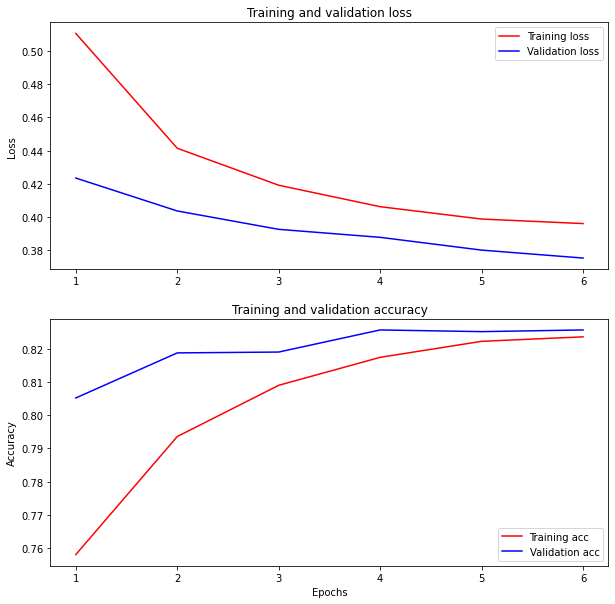

In [33]:
# Plot the training and validation loss and accuracy for the model
plot_loss_accuracy(bert_history)

Accuracy:   0.8477766615555438
ROC-AUC:    0.8916329417000736


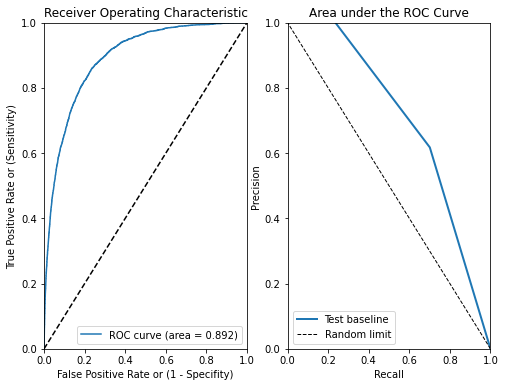

In [34]:
# Calculate the accuracy and ROC-AUC score for the model
accuracy_roc_auc(df_test['truthClass'], y_pred_bert, y_pred_thresh_bert)

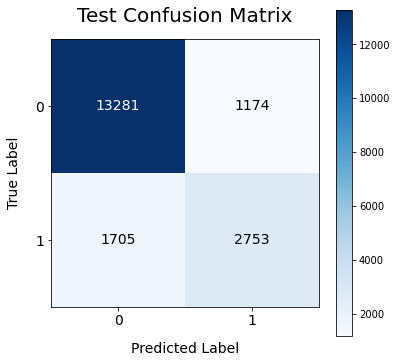

In [35]:
# Plot the confusion matrix for the model
plot_confusion_matrix(df_test['truthClass'], y_pred_thresh_bert)

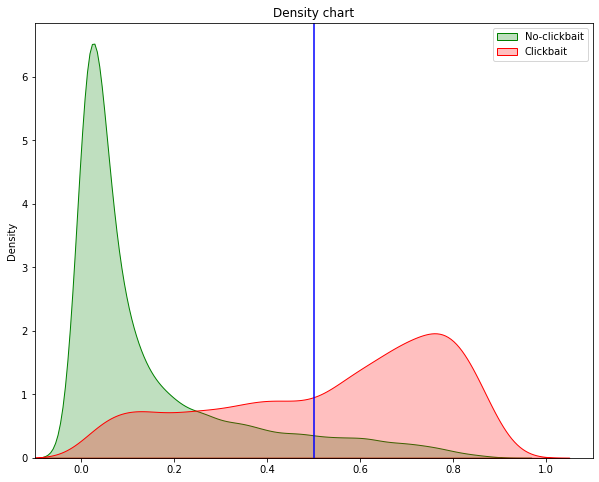

In [36]:
# Plot density chart
plot_density_chart(df_test['truthClass'], y_pred_bert.squeeze())

### 4.2 DistilBERT test

In [37]:
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout = 0.2, 
                          attention_dropout = 0.2, 
                          output_hidden_states = True)

# Instantiate fast DistilBERT tokenizer and model with untrainable layers
distil_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', 
                                               config = config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [38]:
# Encode the training, validation and test text
X_train_ids_distil, X_train_attention_distil =  \
  batch_encode(distil_tokenizer, df_train['postText'].tolist())

X_valid_ids_distil, X_valid_attention_distil = \
  batch_encode(distil_tokenizer, df_valid['postText'].tolist())

X_test_ids_distil, X_test_attention_distil = \
  batch_encode(distil_tokenizer, df_test['postText'].tolist())

In [39]:
# Instantiate the model and plot the model structure and summary
model_distil = build_model(distilBERT)
plot_model(model_distil)
model_distil.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 25)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 25)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 25, 768),                                                    
                                 hidden_states=((No                                         

In [40]:
# Train distilBERT model
distil_history = model_distil.fit(x = [X_train_ids_distil, X_train_attention_distil],
                                  y = df_train['truthClass'].to_numpy(),
                                  epochs = EPOCHS,
                                  batch_size = BATCH_SIZE,
                                  steps_per_epoch = NUM_STEPS,
                                  validation_data = ([X_valid_ids_distil,
                                                      X_valid_attention_distil],
                                  df_valid['truthClass'].to_numpy()),
                                  verbose = 1)

Epoch 1/6
243/243 [==============================] - 20s 60ms/step - loss: 0.5245 - accuracy: 0.7564 - val_loss: 0.4238 - val_accuracy: 0.7901
Epoch 2/6
243/243 [==============================] - 13s 54ms/step - loss: 0.4482 - accuracy: 0.7882 - val_loss: 0.3978 - val_accuracy: 0.8260
Epoch 3/6
243/243 [==============================] - 13s 54ms/step - loss: 0.4255 - accuracy: 0.8074 - val_loss: 0.3864 - val_accuracy: 0.8240
Epoch 4/6
243/243 [==============================] - 13s 54ms/step - loss: 0.4144 - accuracy: 0.8125 - val_loss: 0.3821 - val_accuracy: 0.8265
Epoch 5/6
243/243 [==============================] - 13s 54ms/step - loss: 0.4013 - accuracy: 0.8217 - val_loss: 0.3760 - val_accuracy: 0.8260
Epoch 6/6
243/243 [==============================] - 13s 54ms/step - loss: 0.3999 - accuracy: 0.8237 - val_loss: 0.3731 - val_accuracy: 0.8270


In [41]:
# Generate predictions
y_pred_distil = model_distil.predict([X_test_ids_distil, X_test_attention_distil])
y_pred_thresh_distil = np.where(y_pred_distil >= THRESHOLD, 1, 0)

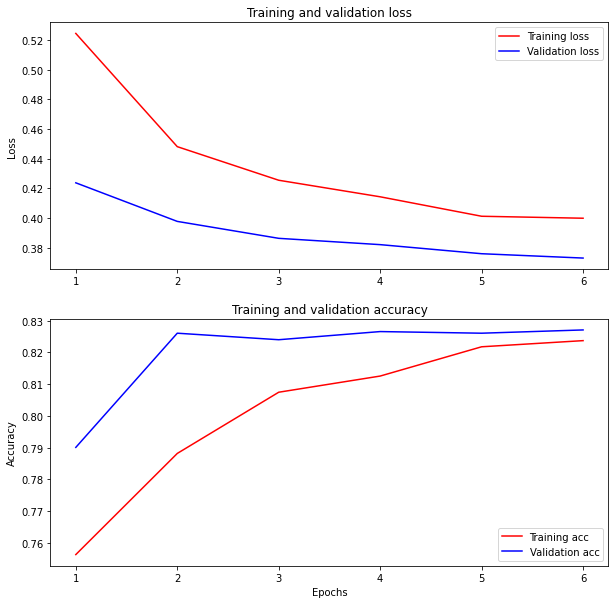

In [42]:
# Plot the training and validation loss and accuracy for the model
plot_loss_accuracy(distil_history)

Accuracy:   0.8477237878707767
ROC-AUC:    0.8904054739581806


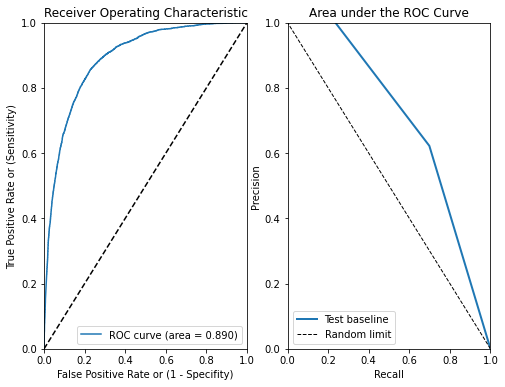

In [43]:
# Calculate the accuracy and ROC-AUC score for the model
accuracy_roc_auc(df_test['truthClass'], y_pred_distil, y_pred_thresh_distil)

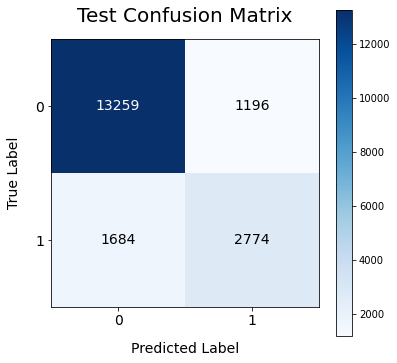

In [44]:
# Plot the confusion matrix for the model
plot_confusion_matrix(df_test['truthClass'], y_pred_thresh_distil)

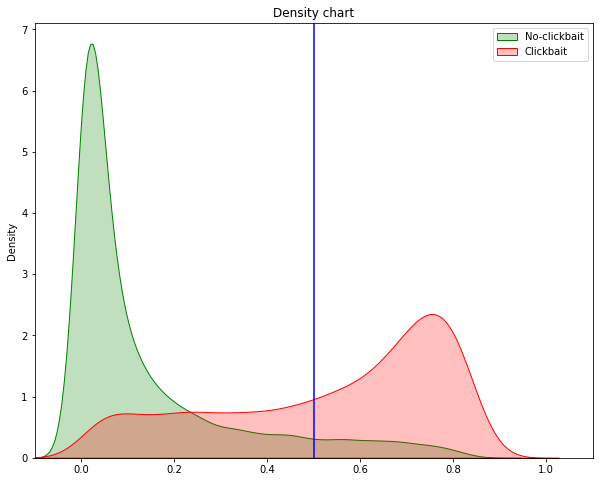

In [45]:
# Plot density chart
plot_density_chart(df_test['truthClass'], y_pred_distil.squeeze())

### 4.3 LSTM test

#### 4.3.1 Clean text from tweets

One of the changes we have to perform on the dataset before deploying a RNN model is text cleaning.

In [46]:
# Download the stopwords, prepare word stemming and define regexp
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
def clean_tweets(text, stem=False):
  """""""""
  A function to clean the text of a tweet.
  """""""""
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
      if stem:
        # Paased to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)

In [48]:
# Create a copy of original datasets
df_train_clean = df_train.copy()
df_valid_clean = df_valid.copy()
df_test_clean = df_test.copy()

In [49]:
# Clean tweets and remove empty rows
df_train_clean['postText'] = df_train_clean['postText'].apply(lambda x: clean_tweets(x))
df_train_clean['postText'].replace('', np.nan, inplace = True)
df_train_clean.dropna(subset = ['postText'], inplace = True)

df_valid_clean['postText'] = df_valid_clean['postText'].apply(lambda x: clean_tweets(x))
df_valid_clean['postText'].replace('', np.nan, inplace = True)
df_valid_clean.dropna(subset = ['postText'], inplace = True)

df_test_clean['postText'] = df_test_clean['postText'].apply(lambda x: clean_tweets(x))
df_test_clean['postText'].replace('', np.nan, inplace = True)
df_test_clean.dropna(subset = ['postText'], inplace = True)

In [50]:
# Print length of cleaned datasets
print("Train Data size:     ", len(df_train_clean))
print("Validation Data size:", len(df_valid_clean))
print("Test Data size:      ", len(df_test_clean))

Train Data size:      15564
Validation Data size: 3895
Test Data size:       18888


In [51]:
# The tokens are converted into sequences and then passed 
# to the pad_sequences() #function
tokenizer = Tokenizer()
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train_clean['postText']),
                        maxlen = MAX_LENGTH)
x_valid = pad_sequences(tokenizer.texts_to_sequences(df_valid_clean['postText']),
                        maxlen = MAX_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test_clean['postText']),
                       maxlen = MAX_LENGTH)

In [52]:
# Fit tokenizer to the train and validation texts
tokenizer.fit_on_texts(df_train['postText'].to_list() + 
                       df_valid['postText'].to_list())

# Extract word inex and calculate vocabulary size
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

In [53]:
# Encode labels and prepare variables
encoder = LabelEncoder()
encoder.fit(df_train_clean['truthClass'].to_list())
y_train = encoder.transform(df_train_clean['truthClass'].to_list())
y_valid = encoder.transform(df_valid_clean['truthClass'].to_list())
y_test = encoder.transform(df_test_clean['truthClass'].to_list())
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#### 4.3.2 Define and evaluate model

In [54]:
# Download GloVe word vector representation
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-08 20:38:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-08 20:38:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-08 20:38:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [55]:
# Define GloVe version
glove_size = 300
glove_file = './glove.6B.' + str(glove_size) + 'd.txt'

# Extract ewmbeddings index
embeddings_index = {}
with open(glove_file) as f:
  for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs

# Print word vector size
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [56]:
# Intialize embedding array
embedding_matrix = np.zeros((vocab_size, glove_size))

# Iterate through word, index in the dictionary and fill the array
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [57]:
# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size, glove_size, 
                                            weights = [embedding_matrix],
                                            input_length = MAX_LENGTH,
                                            trainable = False)

# Define input layer 
weight_initializer = tf.keras.initializers.RandomNormal(seed = RANDOM_STATE) 
sequence_input = Input(shape=(MAX_LENGTH, ), dtype = 'float32')
embedding_sequences = embedding_layer(sequence_input)

# Convolutional layer
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu', 
           kernel_initializer = weight_initializer)(x)

# Passed on to the LSTM layer
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2,
                       kernel_initializer = weight_initializer))(x)

# Fully connected and dropout layers
x = Dense(512, activation='relu', kernel_initializer = weight_initializer)(x)
x = Dropout(0.5, seed = RANDOM_STATE)(x)
x = Dense(512, activation='relu', kernel_initializer = weight_initializer)(x)

# Activation layer to get final output
outputs = Dense(1, activation = 'sigmoid', 
                kernel_initializer = weight_initializer)(x)

# Create model
model_lstm = tf.keras.Model(sequence_input, outputs)

# Compile model
model_lstm.compile(optimizer = Adam(learning_rate = LEARNING_RATE_LSTM), 
                   loss = 'binary_crossentropy', metrics = ['accuracy'])

In [58]:
# Plot the model structure and summary
plot_model(model_lstm)
model_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding (Embedding)       (None, 25, 300)           7838400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 21, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 512)               6604

In [59]:
# Define label weights for address unbalanced dataset
class_weight = {0: 1 - np.count_nonzero(y_train == 0) / len(y_train),
                1: 1 - np.count_nonzero(y_train == 1) / len(y_train)}
print(class_weight)

{0: 0.24106913389874063, 1: 0.7589308661012593}


In [60]:
# Train the model
lstm_history = model_lstm.fit(x_train, y_train, batch_size = BATCH_SIZE, 
                              epochs = EPOCHS,
                              steps_per_epoch = len(x_train) // BATCH_SIZE, 
                              validation_data = (x_valid, y_valid),
                              class_weight = class_weight)

Epoch 1/6
243/243 [==============================] - 54s 177ms/step - loss: 0.2536 - accuracy: 0.3449 - val_loss: 0.6931 - val_accuracy: 0.7584
Epoch 2/6
243/243 [==============================] - 42s 172ms/step - loss: 0.2537 - accuracy: 0.3398 - val_loss: 0.6932 - val_accuracy: 0.2416
Epoch 3/6
243/243 [==============================] - 42s 172ms/step - loss: 0.2535 - accuracy: 0.2406 - val_loss: 0.6932 - val_accuracy: 0.2416
Epoch 4/6
243/243 [==============================] - 42s 174ms/step - loss: 0.2539 - accuracy: 0.2676 - val_loss: 0.6932 - val_accuracy: 0.2416
Epoch 5/6
243/243 [==============================] - 51s 212ms/step - loss: 0.2532 - accuracy: 0.4392 - val_loss: 0.6932 - val_accuracy: 0.2416
Epoch 6/6
243/243 [==============================] - 44s 180ms/step - loss: 0.2541 - accuracy: 0.5281 - val_loss: 0.6932 - val_accuracy: 0.2416


In [61]:
# Generate predictions
y_pred_lstm = model_lstm.predict(x_test)
y_pred_thresh_lstm = np.where(y_pred_lstm >= 0.5, 1, 0)

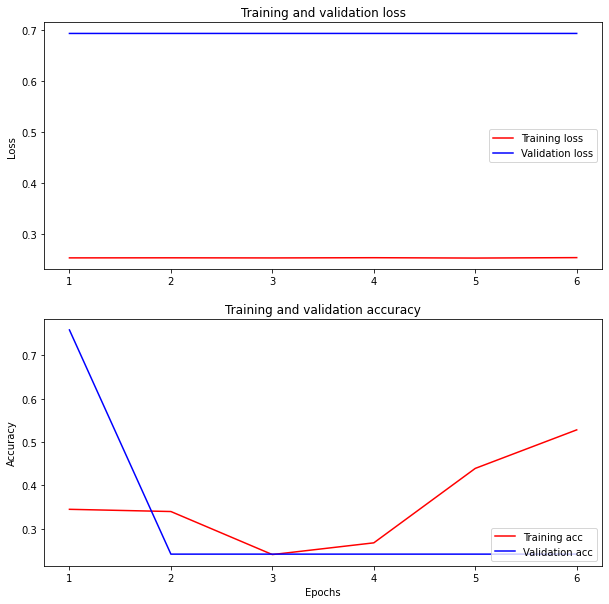

In [62]:
# Plot loss and accuracy curves
plot_loss_accuracy(lstm_history)

Accuracy:   0.23491105463786532
ROC-AUC:    0.5


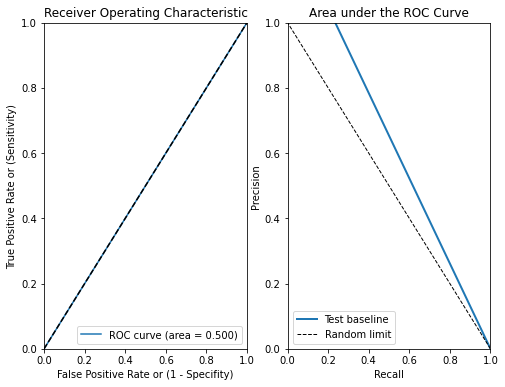

In [63]:
# Calculate the accuracy and ROC-AUC score for the model
accuracy_roc_auc(df_test_clean['truthClass'], y_pred_lstm, y_pred_thresh_lstm)

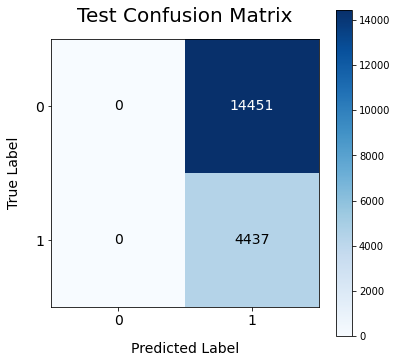

In [64]:
# Plot confusion matrix
plot_confusion_matrix(df_test_clean['truthClass'], y_pred_thresh_lstm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

No handles with labels found to put in legend.


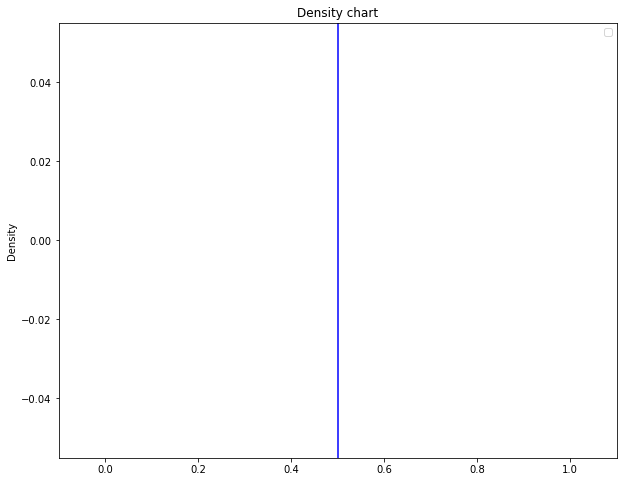

In [65]:
# Plot density chart
plot_density_chart(df_test_clean['truthClass'], y_pred_lstm.squeeze())

## 5. Results comparison

Instead of ussing just the accuracy returned from the train process, we will focus on precision, recall and f1-score. Considering that we have an unbalanced dataset, this analysis will help us draw conlussions about the true/false positives/negatives on the test dataset.

In [66]:
# Calculate the classification report for the model
print(classification_report(df_test['truthClass'], y_pred_thresh_bert, 
                            target_names=["no-clickbait", "clickbait"]))

              precision    recall  f1-score   support

no-clickbait       0.89      0.92      0.90     14455
   clickbait       0.70      0.62      0.66      4458

    accuracy                           0.85     18913
   macro avg       0.79      0.77      0.78     18913
weighted avg       0.84      0.85      0.84     18913



In [67]:
# Calculate the classification report for the model
print(classification_report(df_test['truthClass'], y_pred_thresh_distil,
                            target_names = ["No-clickbait", "Clickbait"]))

              precision    recall  f1-score   support

No-clickbait       0.89      0.92      0.90     14455
   Clickbait       0.70      0.62      0.66      4458

    accuracy                           0.85     18913
   macro avg       0.79      0.77      0.78     18913
weighted avg       0.84      0.85      0.84     18913



In [68]:
# Print classification report
print(classification_report(df_test_clean['truthClass'], y_pred_thresh_lstm,
                            target_names = ["No-clickbait", "Clickbait"]))

              precision    recall  f1-score   support

No-clickbait       0.00      0.00      0.00     14451
   Clickbait       0.23      1.00      0.38      4437

    accuracy                           0.23     18888
   macro avg       0.12      0.50      0.19     18888
weighted avg       0.06      0.23      0.09     18888



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



It seems that both versions of the BERT-like fine-tuned models offer almost the same metrics in both classes. In the other hand, the LSTM model doesn't converge, thus the results are very poor (the test dataset is completely predicted into the same label). We will focus on the best performing solution (distilBERT model) while doing the detailed result analysis:
* The unbalance of the dataset can be also seen in the metrics, as the model is biased towards the "No-clickbait" label. 
* In a real-world scenario, not being able to identify a real clickbait tweet is worse than missclasifying a no-clickbait one. This leads us to focus into the clickbait recall result
* Clickbait recall (0.59) is far from the total accuracy metric (0.85). This difference is another evidence of the model bias.

In order to enhance the clickbait recall metric, we will lower the threshold of the model so we can correct some of the model bias towards the no-clickbait label.

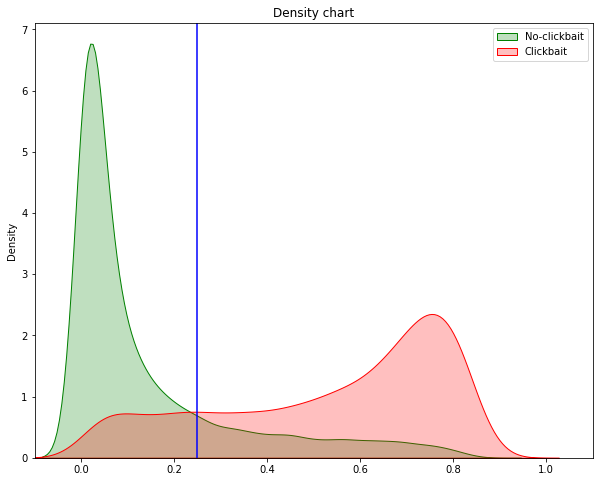

              precision    recall  f1-score   support

No-clickbait       0.93      0.81      0.87     14455
   Clickbait       0.57      0.82      0.67      4458

    accuracy                           0.81     18913
   macro avg       0.75      0.81      0.77     18913
weighted avg       0.85      0.81      0.82     18913



In [69]:
# Recalculate predictions lowering the threshold to 0.25
y_pred_thresh_distil_2 = np.where(y_pred_distil >= 0.25, 1, 0)

# Plot density chart with lower threshold
plot_density_chart(df_test['truthClass'], y_pred_distil.squeeze(), 0.25)

# Calculate again the classification report
print(classification_report(df_test['truthClass'], y_pred_thresh_distil_2,
                            target_names = ["No-clickbait", "Clickbait"]))

The clickbait recall result (0.82) is now above the total accuracy (0.81), resulting in a much more usable Clickbait detection model for the real world.

## 6. Classification errors review

Let's get first some FP and FN tweets from the test dataset in order to draw some conclussions.

In [70]:
# Get the FP and FN from the test dataset
test_pred_fp = df_test.iloc[np.where(y_pred_thresh_distil_2 == 1)[0]].query(
    'truthClass == 0')
test_pred_fn = df_test.iloc[np.where(y_pred_thresh_distil_2 == 0)[0]].query(
    'truthClass == 1')

In [71]:
# Print some FP tweets
print("Clickbait false-positives:\n", test_pred_fp['postText'].values[:5])

Clickbait false-positives:
 ["It's not enough to let employees work flexible schedules if they're still afraid to ask"
 "Out of 15 lakh registered companies in India, 9 lakh don't file returns!"
 'Tense moment plane lands without wheel'
 "Don't abandon the snot if you want to be healthy. #EwwButTrue"
 'How much money will a first-round NFL Draft pick like Mitchell Trubisky make?']


Some of the examples printed seems reasonable to have been missclassified into clickbaits:
* The third tweet tries to capture the reader attention in order to get a visit on the video instead of describing the moment.
* The last one asks the reader a question that could be answered partially on the same tweet

The other ones can be hardly confused with a clickbait, hence we can think that the model has room for improvement. 

In [72]:
# Print some FN tweets
print("Clickbait false-negatives:\n", test_pred_fn['postText'].values[-5:])

Clickbait false-negatives:
 ['27 countries are relying on "the most dangerous man in Europe"'
 "Why some Trump supporters are boycotting the new 'Star Wars' movie with #DumpStarWars"
 "This is what Italy's referendum result means for the world's oldest bank"
 "Mike Pence claims Trump's biggest lie was refreshing"
 'Is race the reason why people want to see a Mayweather vs McGregor fight?']


Almost all these FN examples (except from the third) share that there is a celebrity on it. One of the problems that we have already saw in the EDA's wordcloud is that Donald Trump is one of the most common topics from the dataset, so the model struggles to correctly predict the label.

## 7. Future improvements

Some of the conclussions from the last sections let us identify different possible improvements. Some of the could be:
* Test different BERT checkpoints] from Hugging Face specialized into tweet processing ([bertweet-base-sentiment-analysis](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis)).
* Go from fine-tuning strategies into deep-tuning ones, training the last model layers (or even the whole model).
* Getting a bigger labelled dataset. This improvement could allow us also to easily balance the dataset.
* Balance the dataset through dataset modification discarding some "No-clicbait" tweets or performing data-augmentation techniques into the "Clickbait" ones.
* Investigate deeper the RNN-like models, trying a different approach than the LSTM one or adjusting the hyperparameters and the architecture in order to make it work.
* Adding more variables into the model training pipeline as the news outleet, the author or the full headline.